In [2]:
import numpy as np, pandas as pd, shap, scipy.sparse as sp
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    GridSearchCV,
    RandomizedSearchCV,   
)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LogisticRegression, BayesianRidge
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    average_precision_score,
    PrecisionRecallDisplay,
    roc_auc_score,         
    brier_score_loss,   
    precision_recall_curve,
    fbeta_score,
    make_scorer,         
)
from sklearn.inspection import permutation_importance
from sklearn.base import clone


In [3]:
df = pd.read_pickle(r"C:\Users\zslet\OneDrive\Desktop\df_best.pkl")

In [4]:
def make_model_ready(df,targets_to_remove,target_to_add):
    """
    Prepares the dataframe by selecting model input columns.
    Excludes mortality, outcome, target, and general metadata columns.
    excluding targets with target_to_remvoe: 'clinical_deterioration_any','death_or_deterioration_any'
    """
    all_cols = df.columns.tolist()
    mortality_cols = [c for c in all_cols if c.startswith('mortality_')]
    outcome_cols = [c for c in all_cols if c.startswith('deterioration_')]
    general_cols = [c for c in all_cols if c.startswith('general_')]
    target_cols = ['target'] if 'target' in all_cols else []
    to_remove = [
        'target','Unnamed:0','general_subject_id','mortality_category','Alive',
        'Short-term','Medium-term','Long-term','admit'
    ]
    to_remove =to_remove + targets_to_remove    
    fit_cols = [c for c in all_cols if c not in set(
        outcome_cols + target_cols + to_remove + mortality_cols + general_cols
    )]
    
    print(f"Columns included for modeling ({len(fit_cols)}): {fit_cols[-10:]} ...")
    fit_cols.append(target_to_add) 
    return fit_cols

In [5]:
targets_to_remove = ['organ_support','mortality_class'	,'support_mortality_combo','shortterm_death_or_deterioration',
                     'clinical_deterioration_any','death_or_deterioration_any','mortality_category','suppoert_mortality_combo', 
                    'support_mortality_combo_id']
target_to_add='shortterm_death_or_deterioration'
colz = make_model_ready(df,targets_to_remove, target_to_add )
print(len(colz)) 


Columns included for modeling (101): ['labvalues_potassium_first', 'labvalues_rdw_first', 'labvalues_red_blood_cells_first', 'labvalues_sodium_first', 'labvalues_troponin_t_first', 'labvalues_urea_nitrogen_first', 'labvalues_white_blood_cells_first', 'labvalues_ph_first', 'month_time', 'tod_time'] ...
102


# Explore Random Forest

In [6]:
df_model=df[colz]

TARGET = "shortterm_death_or_deterioration"
X = df_model.drop(columns=[TARGET])
y = df_model[TARGET].astype(int).values
num = X.select_dtypes(include=[np.number]).columns
cat = X.columns.difference(num)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

prep = ColumnTransformer([
    ("num", SimpleImputer(strategy="median"), num),
    ("cat", Pipeline([("imp", SimpleImputer(strategy="most_frequent")),
                      ("ohe", OneHotEncoder(handle_unknown="ignore"))]), cat),
])

rf = RandomForestClassifier(
    n_estimators=600,
    max_depth=None,
    min_samples_leaf=2,
    max_features="sqrt",
    class_weight="balanced",
    n_jobs=-1,
    random_state=42,
)

rf_pipe = Pipeline([("prep", prep), ("clf", rf)])

rf_pipe.fit(X_train, y_train)



,steps,"[('prep', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


# Feature importance

In [29]:
features=rf_pipe.named_steps['prep'].get_feature_names_out()
importance=rf_pipe.named_steps['clf'].feature_importances_
features_df=(pd.DataFrame({'feature': features, 'importance':importance}).sort_values('importance', ascending=False))
top_features_df=features_df.head(10)

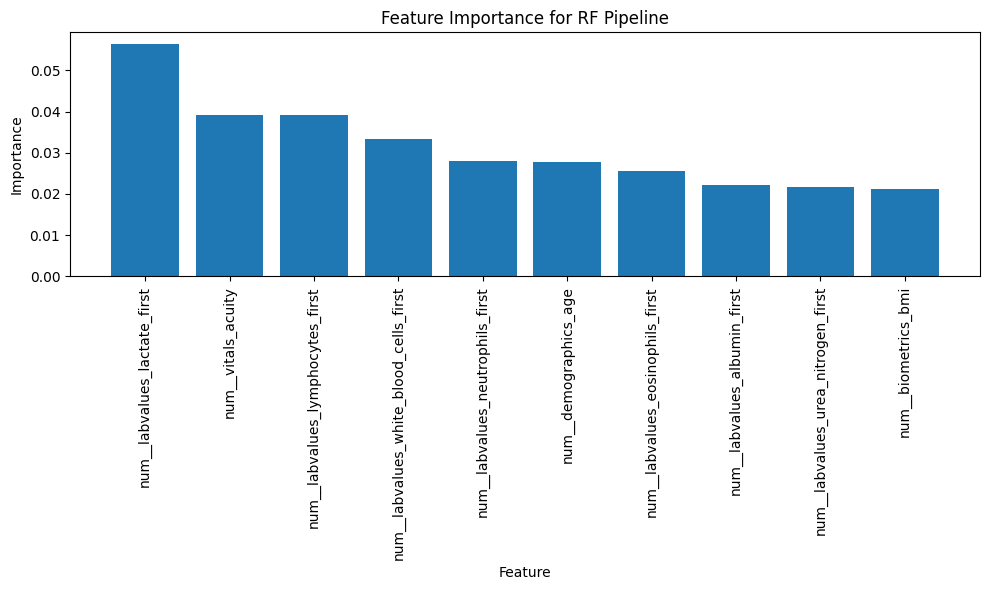

In [30]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(top_features_df['feature'], top_features_df['importance'])
ax.set_title("Feature Importance for RF Pipeline")
ax.set_xlabel("Feature")
ax.set_ylabel("Importance")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
features=rf_pipe.named_steps['prep'].get_feature_names_out()

result = permutation_importance(
    rf_pipe,
    X_test,
    y_test,
    n_repeats=10, 
    random_state=42,
    n_jobs=-1     
)

c:\Users\zslet\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [14]:
df_importance = pd.DataFrame(
    {'feature': features, 'importance_mean': result.importances_mean, 'importance_std': result.importances_std}
)
df_importance = df_importance.sort_values(by='importance_mean', ascending=False)
df_importance

,feature,importance_mean,importance_std
83,num__labvalues_lactate_first,0.005517,0.000423
64,num__vitals_acuity,0.004022,0.000415
84,num__labvalues_lymphocytes_first,0.002282,0.000274
78,num__labvalues_eosinophils_first,0.002073,0.000247
7,num__biometrics_bmi,0.001821,0.000410
...,...,...,...
91,num__labvalues_potassium_first,-0.000145,0.000112
35,num__vitals_resprate_rate_change,-0.000158,0.000088
80,num__labvalues_hematocrit_first,-0.000171,0.000111
19,num__vitals_heartrate_mean,-0.000179,0.000091


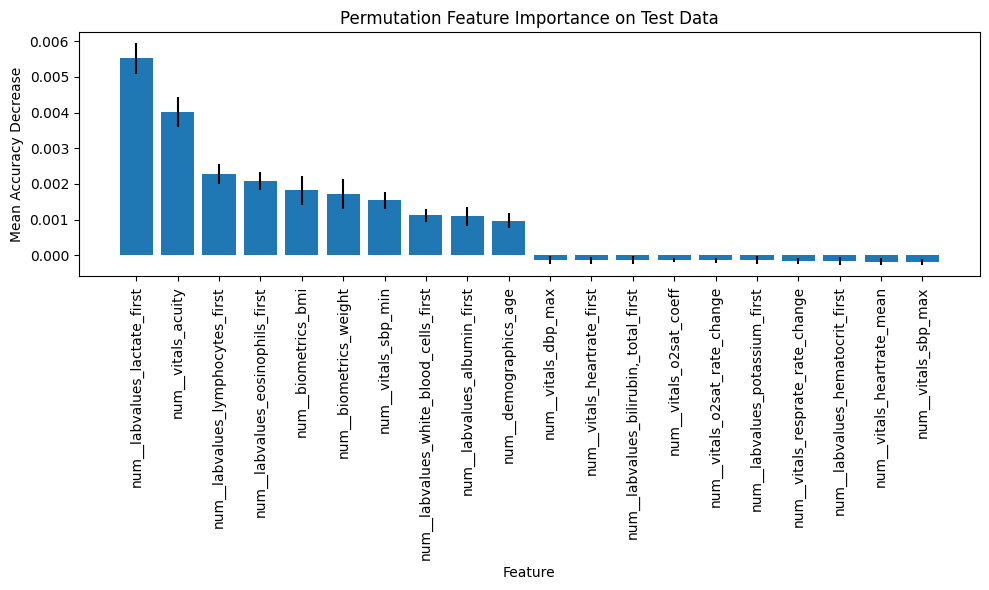

In [21]:
plot_df = pd.concat([df_importance.head(10), df_importance.tail(10)])

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(plot_df['feature'], plot_df['importance_mean'], yerr=plot_df['importance_std'])
ax.set_title("Permutation Feature Importance on Test Data")
ax.set_xlabel("Feature")
ax.set_ylabel("Mean Accuracy Decrease")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [22]:
average_precision_score(y_test, rf_pipe.predict_proba(X_test)[:,1])

0.6137402817378809

In [32]:
result_2 = permutation_importance(
    rf_pipe,
    X_test,
    y_test,
    scoring='average_precision',
    n_repeats=10, 
    random_state=42,
    n_jobs=-1     
)

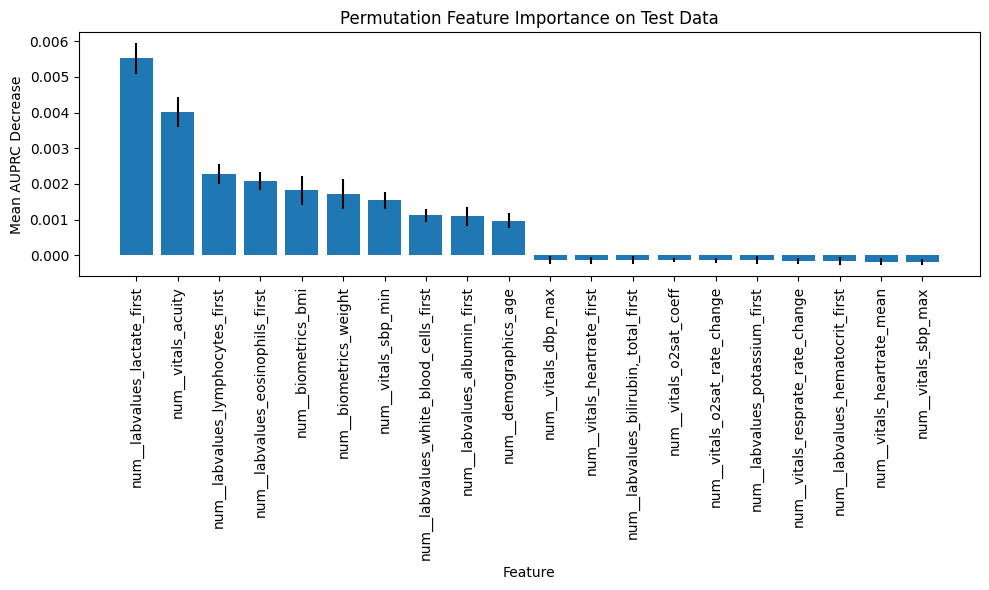

In [33]:
df_importance_2 = pd.DataFrame(
    {'feature': features, 'importance_mean': result.importances_mean, 'importance_std': result.importances_std}
)
df_importance_2 = df_importance.sort_values(by='importance_mean', ascending=False)



plot_df_2 = pd.concat([df_importance_2.head(10), df_importance_2.tail(10)])

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(plot_df_2['feature'], plot_df['importance_mean'], yerr=plot_df_2['importance_std'])
ax.set_title("Permutation Feature Importance on Test Data")
ax.set_xlabel("Feature")
ax.set_ylabel("Mean AUPRC Decrease")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Ablation analysis 

In [77]:
ablation_features=[item.removeprefix('num__') for item in df_importance_2['feature'].head(10).to_list()]
features_all=X_train.columns.to_list()

ablation_results={}
for feature in ablation_features:
    
    other_features = [f for f in features_all if f != feature]
    num_keep = X_train[other_features].select_dtypes(include=[np.number]).columns.tolist()
    cat_keep = X_train[other_features].select_dtypes(exclude=[np.number]).columns.tolist()
    
    prep_2 = ColumnTransformer([
    ("num", SimpleImputer(strategy="median"), num_keep),
    ("cat", Pipeline([("imp", SimpleImputer(strategy="most_frequent")),
                      ("ohe", OneHotEncoder(handle_unknown="ignore"))]), cat_keep),
    ])

    rf_2 = RandomForestClassifier(
        n_estimators=600,
        max_depth=None,
        min_samples_leaf=2,
        max_features="sqrt",
        class_weight="balanced",
        n_jobs=-1,
        random_state=42,
    )

    rf_pipe_2 = Pipeline([("prep", prep_2), ("clf", rf_2)])
    
    rf_pipe_2.fit(X_train[other_features], y_train)
    
    
    ablated_scores = rf_pipe_2.predict_proba(X_test[other_features])[:, 1]
    ablated_auprc = average_precision_score(y_test, ablated_scores)
    
    
    ablation_results[feature] = ablated_auprc
    print(f"AUPRC without {feature}: {ablated_auprc:.4f}")    

    



AUPRC without labvalues_lactate_first: 0.6082
AUPRC without vitals_acuity: 0.6047
AUPRC without labvalues_lymphocytes_first: 0.6119
AUPRC without labvalues_eosinophils_first: 0.6123
AUPRC without biometrics_bmi: 0.6101
AUPRC without biometrics_weight: 0.6085
AUPRC without vitals_sbp_min: 0.6122
AUPRC without labvalues_white_blood_cells_first: 0.6110
AUPRC without labvalues_albumin_first: 0.6110
AUPRC without demographics_age: 0.6098


In [78]:
ablation_results

{'labvalues_lactate_first': 0.6081838300313633,
 'vitals_acuity': 0.6047025791505066,
 'labvalues_lymphocytes_first': 0.6118796419175667,
 'labvalues_eosinophils_first': 0.6123189773014059,
 'biometrics_bmi': 0.6100601044357263,
 'biometrics_weight': 0.6085050894287671,
 'vitals_sbp_min': 0.6122023815246408,
 'labvalues_white_blood_cells_first': 0.6109853506297611,
 'labvalues_albumin_first': 0.610959496382178,
 'demographics_age': 0.609838976091136}

In [79]:

df_ablation_results = pd.DataFrame.from_dict(ablation_results, orient='index')


df_ablation_results = df_ablation_results.reset_index()


df_ablation_results.columns = ['feature', 'AUPRC']
df_ablation_results

,feature,AUPRC
0,labvalues_lactate_first,0.608184
1,vitals_acuity,0.604703
2,labvalues_lymphocytes_first,0.611880
3,labvalues_eosinophils_first,0.612319
4,biometrics_bmi,0.610060
5,biometrics_weight,0.608505
6,vitals_sbp_min,0.612202
7,labvalues_white_blood_cells_first,0.610985
8,labvalues_albumin_first,0.610959
9,demographics_age,0.609839


# sensitivity analysis

In [94]:
full_score= average_precision_score(y_test, rf_pipe.predict_proba(X_test)[:,1])
scores = []
for leaf_amt in [1, 2, 5, 10]:
    rf_clone = clone(rf_pipe)                          
    rf_clone.set_params(clf__min_samples_leaf=leaf_amt)     
    rf_clone.fit(X_train, y_train)
    score = average_precision_score(y_test, rf_clone.predict_proba(X_test)[:, 1])
    scores.append({"min_samples_leaf": leaf_amt, "AUPRC": score})

sensitivity_df = pd.DataFrame(scores).sort_values("AUPRC", ascending=False)
sensitivity_df


,min_samples_leaf,AUPRC
1,2,0.613740
2,5,0.604702
0,1,0.603668
3,10,0.583016


## evaluate trade off between recall and precision

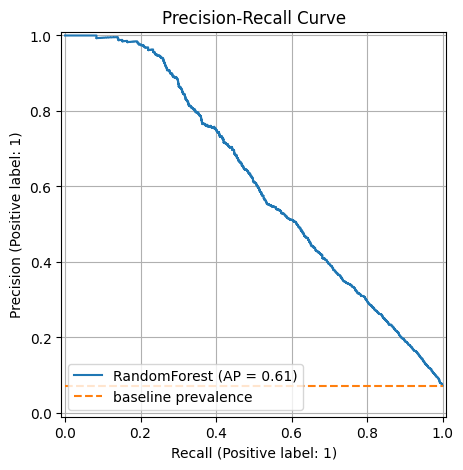

In [103]:
score_y=rf_pipe.predict_proba(X_test)[:,1]

fig, ax = plt.subplots(figsize=(7, 5))
display = PrecisionRecallDisplay.from_predictions(y_test, score_y, ax=ax, name="RandomForest")

outcome_prevalence = y_test.sum() / len(y_test)
ax.plot([0, 1], [outcome_prevalence, outcome_prevalence], linestyle='--', label='baseline prevalence')


ax.set_title("Precision-Recall Curve")
ax.legend(loc="lower left")


plt.grid(True)
plt.show()

# Failure analysis

In [7]:
y_pred = rf_pipe.predict(X_test)

y_proba = rf_pipe.predict_proba(X_test)[:, 1]

mistakes = np.where(y_test != y_pred)[0]

#false positive and false negatives
fps = mistakes[(y_test[mistakes] == 0) & (y_pred[mistakes] == 1)]
fns = mistakes[(y_test[mistakes] == 1) & (y_pred[mistakes] == 0)]



In [17]:
print('false positive in patients who eventually died or had another form of deterioration', df.iloc[fps]['death_or_deterioration_any'].mean())
print('false negatives in patients who eventually died or had another form of deterioration', df.iloc[fns]['death_or_deterioration_any'].mean())
print('total false positive', len(fps))
print('total false negative', len(fns))

false positive in patients who eventually died or had another form of deterioration 0.2911392405063291
false negatives in patients who eventually died or had another form of deterioration 0.329923273657289
total false positive 79
total false negative 1173


In [10]:
fp_df=df.iloc[fps]
fn_df=df.iloc[fns]

In [19]:
fp_df = fp_df.assign(proba=y_proba[fps])
fn_df = fn_df.assign(proba=y_proba[fns])

In [22]:
confident_fp=fp_df.sort_values("proba", ascending=False).head(3)
confident_fn=fn_df.sort_values("proba", ascending=True).head(3)

In [23]:
confident_fp['labvalues_lactate_first'].mean()

5.95

In [24]:
top_features_dict= {'labvalues_lactate_first': 0.6081838300313633,
 'vitals_acuity': 0.6047025791505066,
 'labvalues_lymphocytes_first': 0.6118796419175667,
 'labvalues_eosinophils_first': 0.6123189773014059,
 'biometrics_bmi': 0.6100601044357263,
 'biometrics_weight': 0.6085050894287671,
 'vitals_sbp_min': 0.6122023815246408,
 'labvalues_white_blood_cells_first': 0.6109853506297611,
 'labvalues_albumin_first': 0.610959496382178,
 'demographics_age': 0.609838976091136}

In [ ]:
top10_features_df = pd.DataFrame(top_features_dict.items(), columns=['value', 'importance'])
list_top_10=top10_features_df['value'].to_list()


['labvalues_lactate_first',
 'vitals_acuity',
 'labvalues_lymphocytes_first',
 'labvalues_eosinophils_first',
 'biometrics_bmi',
 'biometrics_weight',
 'vitals_sbp_min',
 'labvalues_white_blood_cells_first',
 'labvalues_albumin_first',
 'demographics_age']

In [37]:
confident_fp_redfx=confident_fp[list_top_10]
confident_fn_redfx=confident_fn[list_top_10]

In [39]:
confident_fp_redfx

,labvalues_lactate_first,vitals_acuity,labvalues_lymphocytes_first,labvalues_eosinophils_first,biometrics_bmi,biometrics_weight,vitals_sbp_min,labvalues_white_blood_cells_first,labvalues_albumin_first,demographics_age
4977,1.1,1.0,15.8,2.0,NaN,NaN,78.0,7.7,NaN,82.0
3417,NaN,3.0,NaN,NaN,23.9,67.176975,139.0,NaN,NaN,60.0
24644,10.8,1.0,30.6,0.1,NaN,NaN,121.0,13.2,5.1,68.0


In [38]:
confident_fn_redfx

,labvalues_lactate_first,vitals_acuity,labvalues_lymphocytes_first,labvalues_eosinophils_first,biometrics_bmi,biometrics_weight,vitals_sbp_min,labvalues_white_blood_cells_first,labvalues_albumin_first,demographics_age
21324,NaN,2.0,NaN,NaN,NaN,NaN,96.0,NaN,NaN,83.0
21378,NaN,2.0,16.2,0.6,30.5,98.397713,165.0,7.9,4.1,42.0
9891,NaN,3.0,NaN,NaN,28.9,81.192968,129.0,NaN,NaN,27.0


In [ ]:
### shap was too computationally expensive to run, had to abord

clf=rf_pipe.named_steps['clf']

explainer = shap.TreeExplainer(clf)

shap_values = explainer.shap_values(X_test)